In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
births = Table.read_table('data/baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')

In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


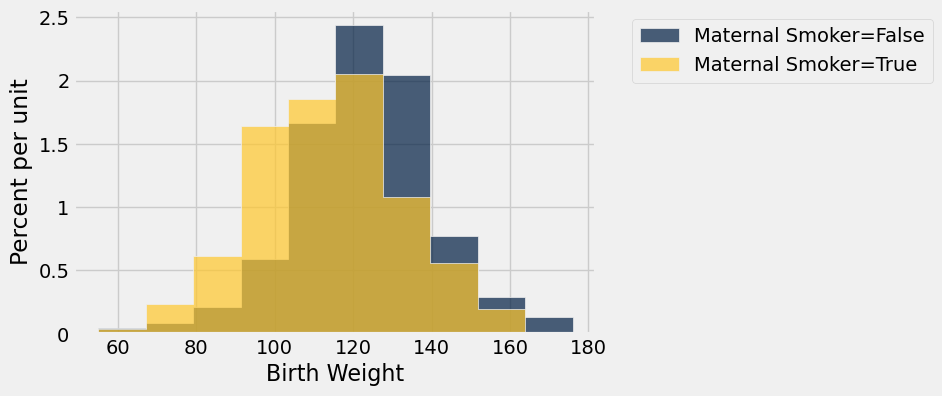

In [5]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [7]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [8]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

In [25]:
def difference_of_means(table, group_label):
    reduced = table.select('Birth Weight', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

difference_of_means(smoking_and_birthweight, 'Maternal Smoker')

-9.266142572024918

In [26]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,True
True,108,True
False,136,False
False,138,True
False,132,False
False,120,True
True,143,True
False,140,False


In [27]:
shuffled_only = original_and_shuffled.select('Birth Weight','Shuffled Label')
shuffled_group_means = shuffled_only.group('Shuffled Label', np.average)
shuffled_group_means

Shuffled Label,Birth Weight average
False,119.207
True,119.861


In [28]:
difference_of_means(shuffled_only, 'Shuffled Label')

0.6535734418087458

In [29]:
def one_simulated_difference_of_means():
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of birth weights and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column('Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')

In [30]:
one_simulated_difference_of_means()

-0.4410652528299579

In [31]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


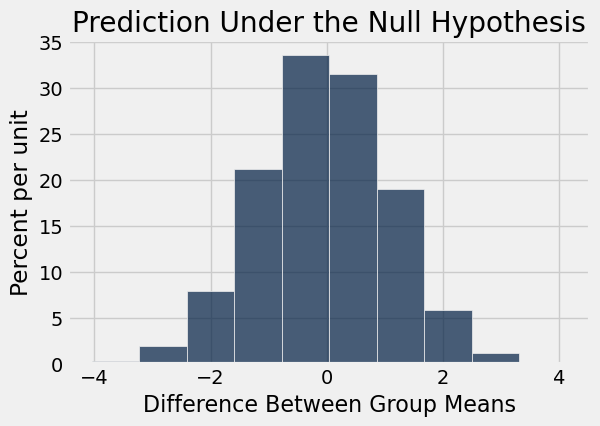

In [33]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plt.title('Prediction Under the Null Hypothesis');

In [34]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

In [35]:
# titanic men vs. women survivors?

# Super Soda

In [2]:
def simulate_one_count(sample_size):
    return np.count_nonzero(np.random.choice(['H', 'T'], sample_size) == 'H')
simulate_one_count(200)

108

In [4]:
num_simulations = 10000
counts = make_array()
for i in np.arange(num_simulations):
    counts = np.append(counts, simulate_one_count(200))

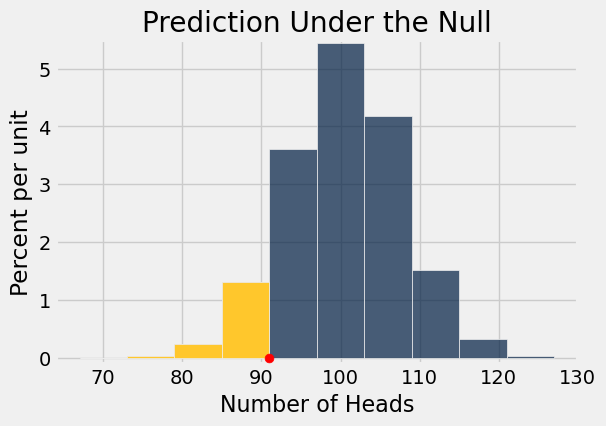

In [6]:
trials = Table().with_column('Number of Heads', counts)
trials.hist(right_end=91)
plt.ylim(-0.001, 0.055)
plt.scatter(91, 0, color='red', s=40, zorder=3)
plt.title('Prediction Under the Null');

In [7]:
np.count_nonzero(counts <= 91)/len(counts)

0.1183

## Changing the number of simulations

In [8]:
# Keeping the data fixed, we can re-run the test with a new simulation under the null
def run_test(num_simulations, sample_size):
    counts = make_array()
    for i in np.arange(num_simulations):
        counts = np.append(counts, simulate_one_count(sample_size))
    return counts

counts = run_test(10000, 200)
np.count_nonzero(counts <= 91)/len(counts)

0.1191

In [9]:
# Let's repeat that 50 times for each number of simulations
tests = Table(['simulations', 'p-value for 91'])
for num_sims in [100, 1000, 10000]:
    for k in np.arange(50):
        counts = run_test(num_sims, 200)
        tests = tests.with_row([
            num_sims, 
            np.count_nonzero(counts <= 91)/len(counts),
        ])
tests.show(3)

simulations,p-value for 91
100,0.12
100,0.09
100,0.11


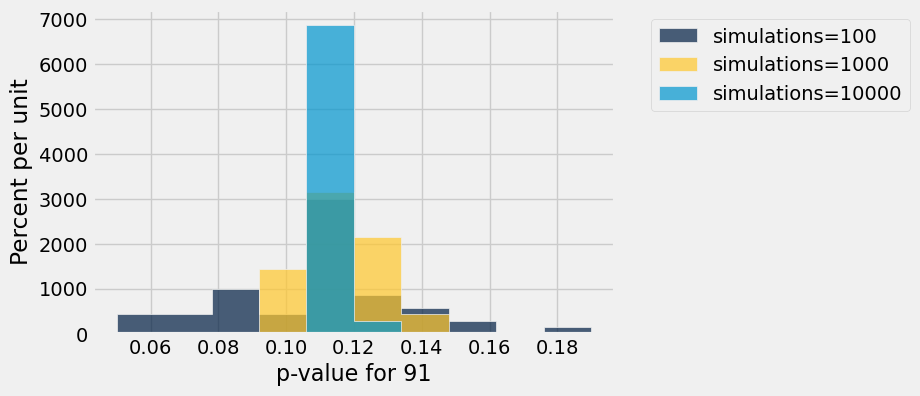

In [10]:
# For larger numbers of simulations, p-values are more consistent
tests.hist(1, group='simulations')

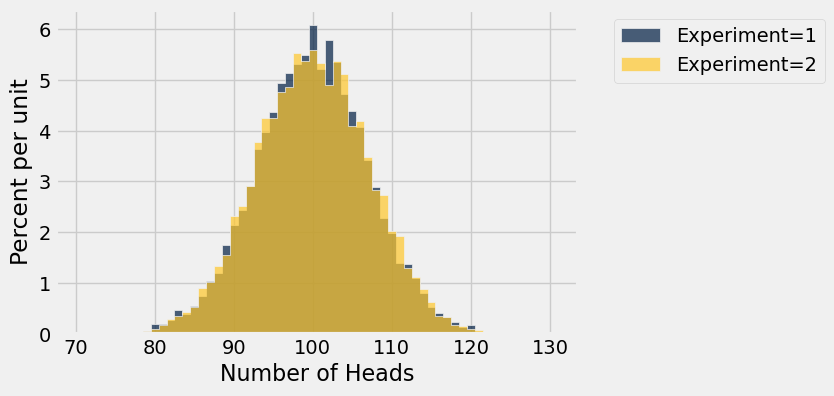

In [11]:
# Since a large number of simulations provides a good estimate of the
# theoretical distribution of the test statistic under the null hypothesis
num_sims = 10000
counts_1 = run_test(num_sims, 200)
counts_2 = run_test(num_sims, 200)
t = Table().with_columns(
    'Experiment', [1] * num_sims + [2] * num_sims,
    'Number of Heads', np.append(counts_1, counts_2))
t.hist(1, group='Experiment', bins=np.arange(70.5, 131, 1))

## Changing the size of the taste test

In [12]:
# Suppose that the true proportion of people who prefer Super Soda is 45%
true_proportion = 0.45
true_distribution = make_array(true_proportion, 1 - true_proportion)
true_distribution

array([ 0.45,  0.55])

In [13]:
# Taste tests with 200 people will give varioius numbers of people who prefer Super Soda
sample_size = 200
sample_proportions(sample_size, true_distribution) * sample_size

array([  99.,  101.])

In [14]:
# If you run a taste test for 200 people, what might you conclude?
def run_experiment(num_simulations, sample_size, true_proportion):
    # Collect data
    true_distribution = make_array(true_proportion, 1 - true_proportion)
    taste_test_results = sample_proportions(sample_size, true_distribution) * sample_size
    observed_stat_from_this_sample = taste_test_results.item(0)
    
    # Conduct hypothesis test
    counts = run_test(num_simulations, sample_size)
    p_value = np.count_nonzero(counts <= observed_stat_from_this_sample) / len(counts)
    return p_value

run_experiment(10000, 200, 0.45)

0.8864

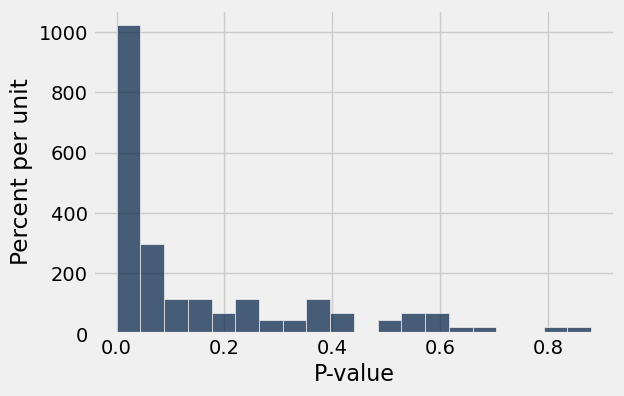

In [16]:
# Let's imagine running our taste test over and over again to see how often we reject the null
true_proportion = 0.45
sample_size = 200
p_values = make_array()
for k in np.arange(100):
    p_value = run_experiment(1000, sample_size, true_proportion)
    p_values = np.append(p_values, p_value)
Table().with_column('P-value', p_values).hist(0, bins=20)